In [3]:
!pip3 install -q -U pandas altair vega_datasets iso3166 vl-convert-python matplotlib seaborn scipy scikit-learn langcodes

In [6]:
import sys
# Append system path
sys.path = [p for p in sys.path if not p.endswith("../..")]  # Cleans duplicated '../.."
sys.path.insert(0, "../")  # This adds `src` to the path
import os
import logging
import pandas as pd
import altair as alt
import langcodes
from collections import Counter, defaultdict
alt.data_transformers.disable_max_rows() # Allow using more than 5000 rows, for now
logging.basicConfig(level=logging.DEBUG, handlers=[logging.StreamHandler(stream=sys.stdout)])
from vega_datasets import data
from helpers import io
from analysis import multimodal_util


%load_ext autoreload
%autoreload 2

/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1238: SyntaxWarning: invalid escape sequence '\%'
  caption += f"Among {modality} datasets, {total_nc_license}\% are Non-Commercially licensed, and {total_restrictive_terms}\% have restrictive terms, but a full {closed_pct}\% of datasets have either a restrictive license or terms."
/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1238: SyntaxWarning: invalid escape sequence '\%'
  caption += f"Among {modality} datasets, {total_nc_license}\% are Non-Commercially licensed, and {total_restrictive_terms}\% have restrictive terms, but a full {closed_pct}\% of datasets have either a restrictive license or terms."
/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1238: SyntaxWarning: invalid escape sequence '\%'
  caption += f"Among {modality} datasets, {total_nc_license}\% are Non-Comm

DEBUG:matplotlib:matplotlib data path: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/Users/nayan/.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is darwin
DEBUG:matplotlib:CACHEDIR=/Users/nayan/.matplotlib
DEBUG:matplotlib.font_manager:font search path [PosixPath('/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf'), PosixPath('/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/afm'), PosixPath('/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts')]
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properti

# Plotting Constants (All Plots)

In [7]:
def times_newroman():
    font = "Times New Roman"

    return {
          "config" : {
               "title": {"font": font},
               "axis": {
               "labelFont": font,
               "titleFont": font
          },
          "header": {
               "labelFont": font,
               "titleFont": font
          },
          "legend": {
               "labelFont": font,
               "titleFont": font
          },
          "text": {
               "font": font
          }
     }
}

alt.themes.register("times_newroman", times_newroman)
alt.themes.enable("times_newroman")

ThemeRegistry.enable('times_newroman')

In [8]:
FONT_SIZE = 16
LEGEND_POSITION = "bottom"
PLOT_TOFILE = True # Whether and where to output plots
PLOT_DIR = "~/dpi-plotsmultimodal/"
PLOT_PPI = 300
MAX_LABELLIMIT = 400 # Large number to avoid label summarization in plots

PLOT_DIR = os.path.expanduser(PLOT_DIR)

# Create directory if needed
if PLOT_TOFILE:
    os.makedirs(PLOT_DIR, exist_ok=True)

## Read Constants and Summaries

Load constants and data summaries from JSON files. Constants provide mappings and criteria for licenses, creator groups, various other categories. Data summaries contain modality-specific information about datasets.

- `all_constants`: Dictionary containing all predefined constants.
- `{text/speech/video}_summaries`: Data summaries by modality.

In [15]:
# Whether and where to output plots
PLOT_TOFILE = True
PLOT_DIR = "~/dpi-plotsmultimodal/"
PLOT_PPI = 300
MAX_LABELLIMIT = 400 # Large number to avoid label summarization in plots

PLOT_DIR = os.path.expanduser(PLOT_DIR)

# Create directory if needed
if PLOT_TOFILE:
    os.makedirs(PLOT_DIR, exist_ok=True)

# Plotting constants
LICENSE_ORDER = ["NC/Acad", "Unspecified", "Commercial"]
LICENSE_PALETTE = ["#e04c71", "#e0cd92", "#82b5cf"]
LICENSE_TERMS_ORDER = [
    "NC/Acad | Model Closed", "NC/Acad | Source Closed", "NC/Acad | Unspecified", "NC/Acad | Unrestricted",
    "Unspecified | Model Closed", "Unspecified | Source Closed", "Unspecified | Unspecified", "Unspecified | Unrestricted",
    "Commercial | Model Closed", "Commercial | Source Closed", "Commercial | Unspecified", "Commercial | Unrestricted",
]
LICENSE_TERMS_PALETTE = [
    '#9d354f', '#c24262', '#e04c71', '#e04c71',  # Shades of #e04c71
    '#9d9066', '#c2b27f', '#e0cd92', '#e0cd92',  # Shades of #e0cd92
    '#5b7f91', '#719db3', '#82b5cf', '#82b5cf',   # Shades of #82b5cf
]

LICENSE_PLOTW = 400
LICENSE_PLOTH = 100
YEAR_CATEGORIES = ["Unknown", "<2013", *list(map(str, range(2013, 2025)))]

# Read constants
all_constants = io.read_all_constants("../../constants/")

# Read Terms data
collection_to_terms_mapper = multimodal_util.load_terms_metadata("data/multimodal_terms_data")

# Read individual modality summaries
text_summaries = io.read_data_summary_json("../../data_summaries/")
logging.info("Checking Text Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(text_summaries, all_constants)

speech_summaries = io.read_data_summary_json("../../data_summaries-speech/")
logging.info("Checking Speech Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(speech_summaries, all_constants)

video_summaries = io.read_data_summary_json("../../data_summaries-video/")
logging.info("Checking Video Data Summaries against Constants")
# analysis_util.check_datasummary_in_constants(video_summaries, all_constants)


INFO:root:Checking Text Data Summaries against Constants
INFO:root:Checking Speech Data Summaries against Constants
INFO:root:Checking Video Data Summaries against Constants


In [19]:
# Prep dataframes
df = multimodal_util.prep_summaries_for_visualization(
    text_summaries,
    speech_summaries,
    video_summaries,
    all_constants,
    collection_to_terms_mapper,
    YEAR_CATEGORIES,
    LICENSE_ORDER,
)

/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1321: SyntaxWarning: invalid escape sequence '\%'
  total_restrictive_terms}\% have restrictive terms, but a full {closed_pct}\% of datasets have either a restrictive license or terms."
/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1321: SyntaxWarning: invalid escape sequence '\%'
  total_restrictive_terms}\% have restrictive terms, but a full {closed_pct}\% of datasets have either a restrictive license or terms."
/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1321: SyntaxWarning: invalid escape sequence '\%'
  total_restrictive_terms}\% have restrictive terms, but a full {closed_pct}\% of datasets have either a restrictive license or terms."


In [435]:
# df_text = df[df["Modality"] == "Text"]
# nan_rows = df_text[df_text["Total Tokens"].isna()]
# print(nan_rows[["Collection", "Total Tokens"]])
# print(nan_rows["Collection"].unique())

In [20]:
df["Data Terms"].value_counts()

Data Terms
Source Closed    3132
Unspecified       310
Unrestricted      255
Model Closed      184
Name: count, dtype: int64

## License Use by Modality

Show the proportion of license types by modality using a stacked bar chart (normalized). Licenses are mapped to a higher-level categorization: either **Non-Commercial/Academic**, **Unspecified**, or **Commercial** depending on the permisiveness of the original license.

In [13]:
# license_chart = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
#     df, "License Type", LICENSE_PALETTE, LICENSE_ORDER, LICENSE_PLOTW, LICENSE_PLOTH, PLOT_DIR, PLOT_PPI, return_license_table=False, configure_chart=True
# )

# license_chart

In [14]:
# license_chart = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
#     df, "License Type", LICENSE_PALETTE, LICENSE_ORDER, LICENSE_PLOTW, LICENSE_PLOTH, PLOT_DIR, PLOT_PPI, return_license_table=False, configure_chart=False
# )

# license_chart

In [983]:
license_terms_chart, license_terms_table = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
# speech_df = multimodal_util.plot_license_terms_stacked_bar_chart_collections(
    df, "License | Terms", LICENSE_TERMS_PALETTE, LICENSE_TERMS_ORDER, 800, 120, PLOT_DIR, PLOT_PPI
)

license_terms_chart

alt.Chart(...)

In [996]:
# import json
print(license_terms_table["Video"])

\begin{table*}[t!]
\centering
\begin{adjustbox}{width=0.98\textwidth}
\begin{tabular}{l|rrrr|r}
\toprule
\textsc{License / Terms} & \textsc{Model Closed} & \textsc{Source Closed} & \textsc{Unspecified} & \textsc{Unrestricted} & \textsc{Total} \\
\midrule
\textsc{NC/Acad} & 0.0 & 21.4 & 0.0 & 10.2 & 31.6 \\
\textsc{Unspecified} & 0.0 & 24.5 & 1.0 & 12.2 & 37.8 \\
\textsc{Commercial} & 0.0 & 22.4 & 0.0 & 8.2 & 30.6 \\
\midrule
\textsc{Total} & 0.0 & 68.4 & 1.0 & 30.6 & 100.0 \\
\bottomrule
\end{tabular}
\end{adjustbox}
\caption{\textbf{A breakdown of Video Dataset licenses, and the Terms attached to their sources.} Among Video datasets, while only 31.6\% are Non-Commerically licensed, or have 68.4\% have restrictive terms, a full 78.6\% of datasets have either a restrictive license or terms.}
\label{tab:video_license_terms_breakdown}
\end{table*}



In [ ]:
# print(license_terms_table["Video"])

## Visualize Creator Categories (e.g. Academic, Industry) by Modality

Show the distribution of creator categories across modalities. Plots a normalized stacked bar chart, and also donut/pie for comparison (for now).

- `df_categories`: DataFrame unlisted to handle multiple creator categories.

In [981]:
# Plotting constants
CREATORCATEGORY_ORDER = ["Academic", "Research Group", "Industry Lab", "Corporation", "Startup", "Other", "Government", "Unspecified"]
CREATORCATEGORY_PALETTE = ["#CF4E9CFF", "#8C57A2FF", "#358DB9FF", "#82581FFF", "#2F509EFF", "#E5614CFF", "#97A1A7FF", "#2E2A2BFF"]
CREATORCATEGORY_PLOTW = 800
CREATORCATEGORY_PLOTH = 120

In [982]:
creator_chart = multimodal_util.plot_stacked_creator_categories(
    df, CREATORCATEGORY_ORDER, CREATORCATEGORY_PALETTE, CREATORCATEGORY_PLOTW, CREATORCATEGORY_PLOTH, PLOT_DIR, collection_level=True
)

creator_chart

alt.Chart(...)

In [17]:
# multimodal_util.plot_donut_creator_categories(
#     df, CREATORCATEGORY_ORDER, CREATORCATEGORY_PALETTE, CREATORCATEGORY_PLOTH, PLOT_DIR
# )

## Visualize Dataset Count by Creator Country/Region and Modality

Global distribution of datasets by modality. Uses a world map with color-coded regions to indicate the count of datasets from different regions.

- `df_countries`: DataFrame with country codes for plotting.
- `base`: Base map (shared across all modalities).
- `charts`: List of modality-specific maps (to concatenate into facets).

In [21]:
# Plotting constants
CREATORCOUNTRY_PLOTDIM = 400
MODALITY_COLORS = {
    "Text": "reds",
    "Speech": "blues",
    "Video": "greens"
}

/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1370: SyntaxWarning: invalid escape sequence '\%'
  closed_pct = round(100 - unspec_or_open, 1)
/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1370: SyntaxWarning: invalid escape sequence '\%'
  closed_pct = round(100 - unspec_or_open, 1)
/Users/nayan/Documents/dpi_try2/Data-Provenance-Collection/src/analysis/../analysis/multimodal_util.py:1370: SyntaxWarning: invalid escape sequence '\%'
  closed_pct = round(100 - unspec_or_open, 1)


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 41 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 62 207825
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 41 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 62 210280
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 41 9
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 62 213508
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


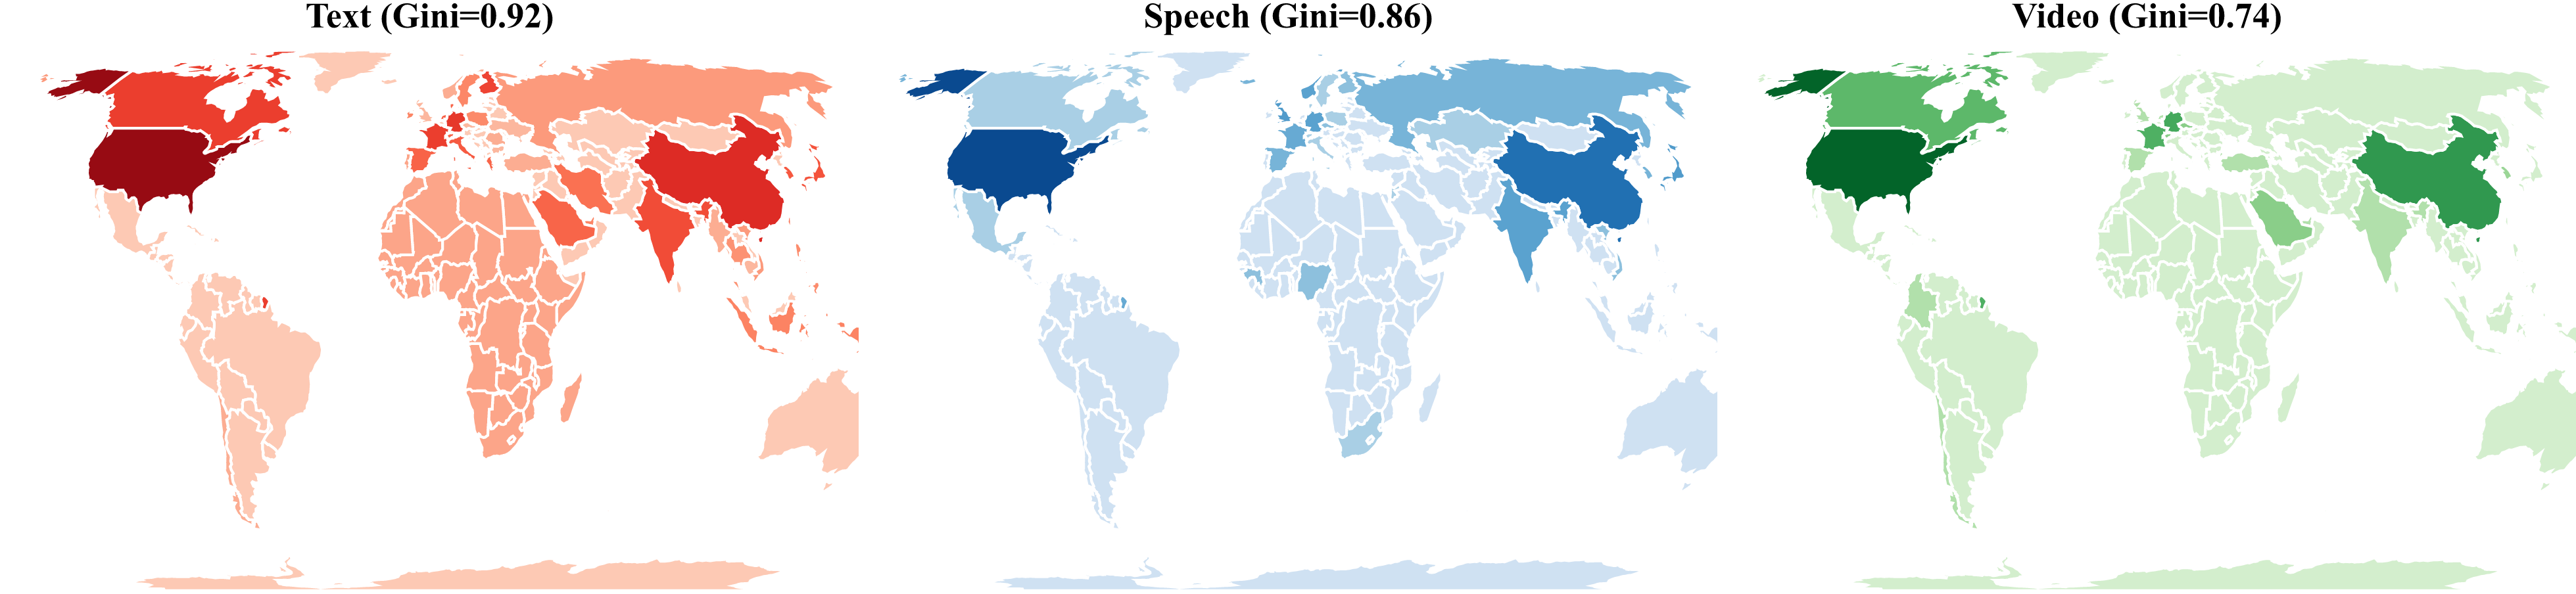

'/Users/nayan/dpi-plotsmultimodal/combined_image.png'

In [40]:
gini_scores = {
    "Text": 0.92,
    "Speech": 0.86,
    "Video": 0.74
}


map_charts = multimodal_util.plot_altair_worldmap_country(
    df,
    data.world_110m.url,
     # World map for plotting
    MODALITY_COLORS,
    CREATORCOUNTRY_PLOTDIM,
    PLOT_DIR,
     gini_scores
)

map_charts

In [ ]:
# map_charts = multimodal_util.plot_altair_worldmap_continent(
#     df,
#     data.world_110m.url, # World map for plotting
#     MODALITY_COLORS,
#     CREATORCOUNTRY_PLOTDIM,
#     PLOT_DIR
# )

# map_charts

## Visualize Data Source Categories by Modality

Distribution of source categories, mapped to higher-level groups in `domain_types.json`, across modalities.

- `df_sources`: DataFrame with grouped sources.

In [ ]:
# Plotting constants
DOMAIN_TYPEMAP = multimodal_util.invert_dict_of_lists(all_constants["DOMAIN_TYPES"])
SOURCECATEGORY_PLOTW = 400
SOURCECATEGORY_PLOTH = 100
SOURCECATEGORY_ORDER = sorted(set(DOMAIN_TYPEMAP.values()) - {"Other"}) + ["Other", "Unspecified"]

In [ ]:
multimodal_util.plot_source_domain_stacked_chart(
    df, DOMAIN_TYPEMAP, SOURCECATEGORY_ORDER, SOURCECATEGORY_PLOTW, SOURCECATEGORY_PLOTH, PLOT_DIR
)

Here, we plot source/domain type distributions by year and modality.

Here, we re-plot the source category distributions, but aggregating within collections for text data (i.e. we use the majority source within collections). For possible ToS mapping (since those annotations are collection level).

In [ ]:
source_chart = multimodal_util.plot_source_domain_stacked_chart_collections(
    df, DOMAIN_TYPEMAP, SOURCECATEGORY_ORDER, SOURCECATEGORY_PLOTW, SOURCECATEGORY_PLOTH, PLOT_DIR
)

source_chart

## Combined Plots

In [ ]:
combined_chart = alt.hconcat(
    license_chart,
    creator_chart,
    source_chart
).configure_axis(
    labelFontSize=FONT_SIZE,
    titleFontSize=FONT_SIZE
).configure_legend(
    titleFontSize=FONT_SIZE,
    labelFontSize=FONT_SIZE,
    orient="bottom",
    columns=2,
    labelLimit=MAX_LABELLIMIT
).configure_title(
    fontSize=FONT_SIZE
).resolve_scale(
    color="independent",
    x="shared",
    y="shared"
).resolve_axis(
    x="shared",
    y="shared"
)

combined_chart_json = combined_chart.to_dict()

combined_chart_json["hconcat"][0]["encoding"]["x"]["axis"] = {"title": "\n"} # For alignment
combined_chart_json["hconcat"][2]["encoding"]["x"]["axis"] = {"title": "\n"}
combined_chart_json["hconcat"][1]["encoding"]["y"]["axis"] = {"title": None, "ticks": False, "labels": False}
combined_chart_json["hconcat"][2]["encoding"]["y"]["axis"] = {"title": None, "ticks": False, "labels": False}

combined_chart = alt.Chart.from_dict(combined_chart_json)

# Save the chart if required
if PLOT_TOFILE:
    combined_chart.save(
        os.path.join(PLOT_DIR, "multimodal-combined_chart.png"),
        ppi=300
    )

combined_chart

### Task Categorization

In [725]:
TASK_TYPEMAP = multimodal_util.invert_dict_of_lists(all_constants["TASK_GROUPS"])
TASKCATEGORY_PLOTW = 280
TASKCATEGORY_PLOTH = 200
TASKCATEGORY_FONT_SIZE = 16
TASKCATEGORY_ORDER = sorted(set(TASK_TYPEMAP.values()) - {"null"})
PLOT_TOFILE_TASKS = True

In [726]:
speech_task_chart_datasets = multimodal_util.plot_tasks_chart(
    df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Speech", "Tasks", "Datasets"
)

# speech_task_chart_datasets

In [727]:
task_chart_text_collections = multimodal_util.plot_tasks_chart(
    # df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Text", "Task Categories", "Datasets"
    df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Text", "Task Categories", "Collections"
)

# task_chart_text_collections

In [728]:
video_task_chart_collections = multimodal_util.plot_tasks_chart(
    df, TASK_TYPEMAP, TASKCATEGORY_ORDER, TASKCATEGORY_PLOTW, TASKCATEGORY_PLOTH, PLOT_DIR, TASKCATEGORY_FONT_SIZE, "Video", "Task Categories", "Datasets"
)

# video_task_chart_collections

In [729]:
combined_tasks_chart = multimodal_util.concatenate_task_charts(task_chart_text_collections, speech_task_chart_datasets, video_task_chart_collections, 14)

if PLOT_TOFILE_TASKS:
    combined_tasks_chart.save(
        os.path.join(PLOT_DIR, "multimodal-combined_tasks_chart.png"),
        ppi=300
    )

In [730]:
combined_tasks_chart

alt.HConcatChart(...)

### Visualize Dataset dimensions by tokens (Datasets and Collections)
Tokens calculation

#### Datasets split by tokens bins


In [735]:
# df_tokens.columns

#### Collections split by tokens bins


In [739]:
# bins_collection = [0, 1000000, 50000000,100000000, 500000000, 1000000000, float('inf')]
# labels_collection = ['0-1M', '1M-50M', '50M-100M', '100M-500M', '500m-1B', '1B+']
text_bins_collection = [0, 1000000, 10000000,100000000, 1000000000, 10000000000, float('inf')]
text_labels_collection = ['0-1M', '1M-10M', '10M-100M', '100M-1B', '1B-10B', '10B+']

# df_tokens = multimodal_util.tokens_calculation(df)
text_collection_chart, text_max_count_collection = multimodal_util.data_aggregation_for_chart(
    df,'Text', text_bins_collection, text_labels_collection, by_collection=True, measure_column='Total Tokens', group_column='Tokens')

speech_bins_collection = [0, 100, 1000,10000, 100000, float('inf')]
speech_labels_collection = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
speech_collection_chart, speech_max_count_collection = multimodal_util.data_aggregation_for_chart(
    df,'Speech', speech_bins_collection, speech_labels_collection, by_collection=False, measure_column='Hours', group_column='Hours')

video_bins_collection = [0, 100, 1000,10000, 100000, float('inf')]
video_labels_collection = ['0-100', '100-1K', '1K-10K', '10K-100K', '100K+']
video_collection_chart, video_max_count_collection = multimodal_util.data_aggregation_for_chart(
    df,'Video', speech_bins_collection, speech_labels_collection, by_collection=False, measure_column='Hours', group_column='Hours')

../analysis/multimodal_util.py:1539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modality[group_column] = pd.cut(df_modality[measure_column], bins=bins, labels=labels, right=False)
../analysis/multimodal_util.py:1539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modality[group_column] = pd.cut(df_modality[measure_column], bins=bins, labels=labels, right=False)


#### Combine graphs for dataset and collections split


In [857]:
# chart1 = multimodal_util.chart_creation(
#     dataset_chart, 
#     max_count_dataset, 
#     x_field='Token Groups',  
#     labels=labels_dataset,
#     ratio=1.15,
#     title='Token distributions by Datasets',
#     width=400,
#     height=300,
#     color='skyblue'
# )

DIM_CHART_WIDTH = 300
DIM_CHART_HEIGHT = 200


text_dim_chart = multimodal_util.chart_creation(
    text_collection_chart, 
    text_max_count_collection, 
    x_field='Tokens',  
    labels=text_labels_collection,
    ratio=1.15,
    title='Text (Tokens)',
    width=DIM_CHART_WIDTH,
    height=DIM_CHART_HEIGHT,
    color='salmon'
)

speech_dim_chart = multimodal_util.chart_creation(
    speech_collection_chart, 
    speech_max_count_collection, 
    x_field='Hours',  
    labels=speech_labels_collection,
    ratio=1.15,
    title='Speech (Hours)',
    width=DIM_CHART_WIDTH,
    height=DIM_CHART_HEIGHT,
    color='skyblue'
)

video_dim_chart = multimodal_util.chart_creation(
    video_collection_chart, 
    video_max_count_collection, 
    x_field='Hours',  
    labels=video_labels_collection,
    ratio=1.15,
    title='Video (Hours)',
    width=DIM_CHART_WIDTH,
    height=DIM_CHART_HEIGHT,
    color='forestgreen'
)


# Concatenate the two charts horizontally with different scales for the y-axes
combined_chart = multimodal_util.combined_dim_charts(text_dim_chart, speech_dim_chart, video_dim_chart)
combined_chart = combined_chart.configure_view(strokeOpacity=0)

# Save the plot if PLOT_TOFILE is True
if PLOT_TOFILE:
    output_file = os.path.join(PLOT_DIR, "Token_&_collection.png")
    combined_chart.save(output_file, scale_factor=PLOT_PPI/100)

# Display the chart
combined_chart.display()

alt.HConcatChart(...)

In [ ]:
# df.columns

### Source Categories by Hours/Tokens

In [998]:
INCLUDE_TOP_N_CATEGORIES = 8
SRC_CAT_CUMULATIVE_PLOTW = 380
SRC_CAT_CUMULATIVE_PLOTH = 140
EARLIEST_YEAR = 2013

In [999]:
speech_chart_sourceyearhours = multimodal_util.plot_temporal_cumulative_sources(
    df, "Speech", INCLUDE_TOP_N_CATEGORIES, "Hours", EARLIEST_YEAR, SRC_CAT_CUMULATIVE_PLOTW, SRC_CAT_CUMULATIVE_PLOTH)

In [1000]:
video_chart_sourceyearhours = multimodal_util.plot_temporal_cumulative_sources(
    df, "Video", INCLUDE_TOP_N_CATEGORIES, "Hours", EARLIEST_YEAR, SRC_CAT_CUMULATIVE_PLOTW, SRC_CAT_CUMULATIVE_PLOTH)

In [1001]:
text_chart_sourceyearhours = multimodal_util.plot_temporal_cumulative_sources(
    df, "Text", 14, "Total Tokens", EARLIEST_YEAR, SRC_CAT_CUMULATIVE_PLOTW, SRC_CAT_CUMULATIVE_PLOTH)

In [1002]:
combined_cumulative_source_chart = multimodal_util.combined_dim_charts(text_chart_sourceyearhours, speech_chart_sourceyearhours, video_chart_sourceyearhours)

In [ ]:
def post_process_combined_chart(hconchart):
    return hconchart.configure_axis(
        grid=False,
        labelFontSize=12,
        titleFontSize=14
    ).configure_axisX(
        labelExpr="datum.value == '<2013' || datum.value == '2014' || (year(datum.value) % 2 == 0 && datum.value != '<2013' && datum.value != '2014') ? datum.label : ''",
        labelAngle=0
    )

combined_cumulative_source_chart = post_process_combined_chart(combined_cumulative_source_chart)

In [1003]:
combined_cumulative_source_chart

alt.HConcatChart(...)

## Gini Coefficient Across Languages by (Cumulative) Total Hours

In [905]:
df_textlanguagesfamilycumulativehoursgini, df_text_lang_explode = multimodal_util.prep_text_for_lang_gini(df, all_constants)
df_textlanguagesfamilycumulativehoursgini['Type'] = 'Text ' + df_textlanguagesfamilycumulativehoursgini['Type']
df_text_lang_explode['Modality'] = 'Text'
df_speechlanguagesfamilycumulativehoursgini, df_speechlanguagesn = multimodal_util.prepare_speech_for_gini(df)
df_speechlanguagesfamilycumulativehoursgini['Type'] = 'Speech ' + df_speechlanguagesfamilycumulativehoursgini['Type']
df_speechlanguagesn['Modality'] = 'Speech'
df_speech_text_gini = pd.concat([df_textlanguagesfamilycumulativehoursgini,df_speechlanguagesfamilycumulativehoursgini])
df_speech_text_spec = pd.concat([df_text_lang_explode,df_speechlanguagesn])
lang_gini_chart = multimodal_util.plot_temporal_ginis(df_speech_text_gini, df_speech_text_spec, ["Language (ISO)", "Language Family"], columns=2)

Text | Language (ISO) | 509
Text | Language Family | 21
Speech | Language (ISO) | 276
Speech | Language Family | 36


In [906]:
df_gini_locs, df_spec_locs = multimodal_util.prepare_geo_gini_data(df)
geo_gini_chart = multimodal_util.plot_temporal_ginis(df_gini_locs, df_spec_locs, ["Countries"], columns=4)

../analysis/multimodal_util.py:2144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_video_locs["Dimension"] = df_video_locs["Hours"]
../analysis/multimodal_util.py:2145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
../analysis/multimodal_util.py:2151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Text | Countries | 55
Speech | Countries | 29
Video | Countries | 22


In [916]:
df_spec_src = multimodal_util.prepare_data_cum_barchart(df_spec_locs, "Countries")
geo_barchart = multimodal_util.plot_cum_barchart(df_spec_src, "Countries")

In [917]:
df_spec_src_lang = multimodal_util.prepare_data_cum_barchart(df_speech_text_spec, "Language (ISO)")
lang_barchart = multimodal_util.plot_cum_barchart(df_spec_src_lang, "Language (ISO)")

In [918]:
geo_barchart

alt.Chart(...)

In [919]:
lang_barchart

alt.Chart(...)

In [920]:
geo_gini_chart

alt.LayerChart(...)

In [921]:
lang_gini_chart

alt.LayerChart(...)

In [922]:
df.columns

Index(['Unique Dataset Identifier', 'Dataset Name', 'Paper Title',
       'Dataset URL', 'GitHub URL', 'Hugging Face URL', 'Papers with Code URL',
       'ArXiv URL', 'Semantic Scholar Corpus ID', 'Collection',
       'Collection URL', 'Languages', 'Task Categories', 'Text Sources',
       'Model Generated', 'Format', 'Human Annotation',
       'Derived from Datasets', 'Creators', 'Licenses', 'License Notes',
       'License Verified By', 'Dataset Filter IDs', 'Bibtex',
       'Inferred Metadata', 'Text Metrics', 'GitHub License',
       'HF Yaml License', 'HF Config License', 'PwC License',
       'License Use (DataProvenance)', 'License Attribution (DataProvenance)',
       'License Share Alike (DataProvenance)',
       'License Use (DataProvenance IgnoreOpenAI)',
       'License Attribution (DataProvenance IgnoreOpenAI)',
       'License Share Alike (DataProvenance IgnoreOpenAI)',
       'License Use (HuggingFace)', 'License Attribution (HuggingFace)',
       'License Share Alike (H

In [968]:
df_text = df[df["Modality"] == "Text"]
df_text["Source"] = df_text["Text Sources"]
df_speech = df[df["Modality"] == "Speech"]
df_speech["Task Categories"] = df_speech["Tasks"]
df_video = df[df["Modality"] == "Video"]
df_video["Source"] = df_video["Source Category"]
df_mod_merged = pd.concat([df_text, df_speech, df_video])
# df_text_speech_merged = pd.concat([df_text, df_speech])

# \textsc{Modality} & \multicolumn{2}{c}{\textsc{Dimensions}} & \multicolumn{2}{c}{\textsc{Sources}} & \multicolumn{2}{c}{\textsc{Tasks}} 
# & \multicolumn{2}{c}{\textsc{Creators}} & \multicolumn{2}{c}{\textsc{Languages}} & \textsc{Licenses}  \\
 # & \textsc{Datasets} & \textsc{|Size|} & \textsc{|Unique|} & \textsc{Domains} & \textsc{|Unique|} & \textsc{Categories} & \textsc{|Unique|} & \textsc{Countries} & \textsc{|Unique|} & \textsc{|Families|} & \textsc{|Unique|} \\

# Dimensions, Sources, Tasks, Creators, Licenses
# Year Released? 
def unpack_key_stats(df_spec, sum_col, task_col, src_col):
    df_spec['License Resolved'] = df_spec['Licenses'].apply(lambda x: [d['License'] for d in x])
    return {
        "Num Datasets": len(df_spec),
        "Total Size": df_spec[sum_col].sum(),
        "Mean Size": df_spec[sum_col].sum() / len(df_spec),
        "Unique Creators": df_spec.explode("Creators")["Creators"].nunique(),
        "Countries": df_spec.explode("Countries")["Countries"].nunique(),
        "Sources": df_spec.explode(src_col)[src_col].nunique(),
        "Source Categories": df_spec.explode("Source Category")["Source Category"].nunique(),
        "Task Categories": df_spec.explode(task_col)[task_col].nunique(),
        "Unique Licenses": df_spec.explode("License Resolved")["License Resolved"].nunique(),
    }

def unpack_total_stats(df_spec):
    df_spec['License Resolved'] = df_spec['Licenses'].apply(lambda x: [d['License'] for d in x])
    return {
        "Num Datasets": len(df_spec),
        # "Total Size": df_spec[sum_col].sum(),
        # "Mean Size": df_spec[sum_col].sum() / len(df_spec),
        "Unique Creators": df_spec.explode("Creators")["Creators"].nunique(),
        "Countries": df_spec.explode("Countries")["Countries"].nunique(),
        "Sources": df_spec.explode("Source")["Source"].nunique(),
        "Source Categories": df_spec.explode("Source Category")["Source Category"].nunique(),
        "Task Categories": df_spec.explode("Task Categories")["Task Categories"].nunique(),
        "Unique Licenses": df_spec.explode("License Resolved")["License Resolved"].nunique(),
    }

/var/folders/fl/3cgkr5r165v5rx824jlz0x8m0000gn/T/ipykernel_27257/668153605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["Source"] = df_text["Text Sources"]
/var/folders/fl/3cgkr5r165v5rx824jlz0x8m0000gn/T/ipykernel_27257/668153605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_speech["Task Categories"] = df_speech["Tasks"]
/var/folders/fl/3cgkr5r165v5rx824jlz0x8m0000gn/T/ipykernel_27257/668153605.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [964]:
unpack_key_stats(df_video, "Hours", "Task Categories", "Source Category")

/var/folders/fl/3cgkr5r165v5rx824jlz0x8m0000gn/T/ipykernel_27257/1118880734.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spec['License Resolved'] = df_spec['Licenses'].apply(lambda x: [d['License'] for d in x])


{'Num Datasets': 98,
 'Total Size': 832121.17,
 'Mean Size': 8491.032346938777,
 'Unique Creators': 91,
 'Countries': 22,
 'Sources': 24,
 'Source Categories': 24,
 'Task Categories': 27,
 'Unique Licenses': 11}

In [965]:
unpack_key_stats(df_speech, "Hours", "Task Categories", "Source")

/var/folders/fl/3cgkr5r165v5rx824jlz0x8m0000gn/T/ipykernel_27257/1118880734.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spec['License Resolved'] = df_spec['Licenses'].apply(lambda x: [d['License'] for d in x])


{'Num Datasets': 95,
 'Total Size': 775600.41,
 'Mean Size': 8164.214842105263,
 'Unique Creators': 124,
 'Countries': 29,
 'Sources': 51,
 'Source Categories': 16,
 'Task Categories': 18,
 'Unique Licenses': 19}

In [966]:
unpack_key_stats(df_text, "Total Tokens", "Task Categories", "Text Sources")

/var/folders/fl/3cgkr5r165v5rx824jlz0x8m0000gn/T/ipykernel_27257/1118880734.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spec['License Resolved'] = df_spec['Licenses'].apply(lambda x: [d['License'] for d in x])


{'Num Datasets': 3688,
 'Total Size': 2068834713765.95,
 'Mean Size': 560963859.4810059,
 'Unique Creators': 518,
 'Countries': 55,
 'Sources': 713,
 'Source Categories': 23,
 'Task Categories': 384,
 'Unique Licenses': 49}

In [967]:
unpack_total_stats(df_mod_merged)

{'Num Datasets': 3881,
 'Unique Creators': 639,
 'Countries': 63,
 'Sources': 778,
 'Source Categories': 63,
 'Task Categories': 427,
 'Unique Licenses': 54}

In [975]:
print(df_speech_text_spec["Language (ISO)"].nunique())
print(df_speech_text_spec["Language Family"].nunique())
# df_text_speech_merged["Language Families"]

747
37


In [976]:
len(df)

3881

In [985]:
df_gini_locs[df_gini_locs["Year Released"] == "2024"]

,Year Released,Gini,Gini Mean,Gini Lower,Gini Upper,Type,Modality
12,2024,"(0.9170403447256023, 0.837364013815281, 0.9600...",0.917040,0.837364,0.960079,Text,Text
12,2024,"(0.8576580304218534, 0.7518127214465313, 0.918...",0.857658,0.751813,0.918210,Speech,Speech
12,2024,"(0.7418476482830463, 0.588321222808532, 0.8601...",0.741848,0.588321,0.860144,Video,Video


In [997]:
df_text["Collection"].nunique()

102